<a href="https://colab.research.google.com/github/MajidNoorani/Census-Income-prediction/blob/main/Census_Income_TabTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the implementation of TabTransformers which is based on the paper named

[TabTransformer: Tabular Data Modeling Using Contextual Embeddings](https://arxiv.org/abs/2012.06678)

on [Census Income](https://archive.ics.uci.edu/dataset/20/census+income) dataset.

# Imports

In [ ]:
# if running on colab, restart session after installation
!pip install tensorflow --upgrade
!pip install keras --upgrade

In [52]:
import keras
from keras import layers
from keras import ops
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial
from typing import List
from sklearn.metrics import f1_score, confusion_matrix


# Data download and preparation

The data does not have headers and we need to set them manually

In [53]:
HEADERS = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]


In [54]:
train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=HEADERS)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=HEADERS)
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [55]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [56]:
# first row of test data is not valid and should be dropped
test_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [57]:
test_data = test_data.iloc[1:, :]
# in train set we don't have dots in income_bracket column, so we remove them
test_data.income_bracket = test_data.income_bracket.apply(
    lambda value: value.replace(".", "")
)

Since *tf_data.experimental.make_csv_dataset* gets data path, we need to save
them in hard drive

In [58]:
train_data_path = "train_data.csv"
test_data_path = "test_data.csv"

train_data.to_csv(train_data_path, index=False, header=False)
test_data.to_csv(test_data_path, index=False, header=False)

we need to categorize columns into ***NUMERIC***, ***Categorical***, ***Weight***, and ***Target*** and also make vocabulary for categorical ones.

in addition, there is column for weights of instances which will be accounted in a different way.

In [59]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "fnlwgt"

# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]

In [60]:
# class weights:
class_samples_ = train_data['income_bracket'].value_counts().to_dict()
class_samples = {}
for i, key in enumerate(class_samples_.keys()):
  class_samples[i] = class_samples_[key]

print(class_samples_)
print(class_samples)
total = sum(class_samples.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

class_weight = {k: (1 - (v / total)) for k, v in class_samples.items()}
print(class_weight)

{' <=50K': 24720, ' >50K': 7841}
{0: 24720, 1: 7841}
{0: 0.2408095574460244, 1: 0.7591904425539756}


we need to specify the default values for each column category

In [61]:
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in HEADERS
]


## Data Pipeline

In [62]:
# we map the strings into integers
# default value for output is int
# (options:"one_hot", "multi_hot", "count", or "tf_idf")
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, num_oov_indices=0
)

# we make a dictionary for lookup layers. each key is a categorical feature
lookup_dict = {}
for feature_name in CATEGORICAL_FEATURE_NAMES:
    vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
    # Create a lookup to convert a string values to an integer indices.
    # Since we are not using a mask token, nor expecting any out of vocabulary
    # (oov) token, we set mask_token to None and num_oov_indices to 0.
    lookup = layers.StringLookup(
        vocabulary=vocabulary, num_oov_indices=0
    )
    lookup_dict[feature_name] = lookup

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [88]:
def encode_features_and_target(features, target):
    # this function maps each batch to the integers that are within the lookup table of each categorical column
    target = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    for feature_name in CATEGORICAL_FEATURE_NAMES:
        features[feature_name] = lookup_dict[feature_name](features[feature_name])
    target = ops.expand_dims(target, -1)
    # The model realizes that we are passing sample weights to it
    return features, target, weights

In [89]:
def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    # tf.data.dataset.make_csv_dataset returns a dataset, where each element is a (features, labels) tuple that corresponds to a batch of batch_size CSV rows
    dataset = (
        tf.data.experimental.make_csv_dataset(
            csv_file_path,
            batch_size=batch_size,
            column_names=HEADERS,
            column_defaults=COLUMN_DEFAULTS,
            label_name=TARGET_FEATURE_NAME,
            num_epochs=1,
            header=False,
            na_value="?",
            shuffle=shuffle,
        )
        .map(encode_features_and_target, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    )
    return dataset.cache()

In [90]:
get_dataset_from_csv("/content/train_data.csv").take(1)

<_TakeDataset element_spec=(OrderedDict([('age', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('workclass', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('education', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('education_num', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('marital_status', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('occupation', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('relationship', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('race', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('gender', TensorSpec(shape=(None,), dtype=tf.int64, name=None)), ('capital_gain', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('capital_loss', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('hours_per_week', TensorSpec(shape=(None,), dtype=tf.float32, name=None)), ('native_country', TensorSpec(shape=(None,), dtype=tf.int64, name=None))]), TensorSpec(shape=(None, 1), dtype=t

# Model Inputs

In [92]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
      inputs[feature_name] = layers.Input(
          name=feature_name, shape=(), dtype="float32"
      )
    return inputs

In [93]:
def encode_inputs(inputs, embedding_dims):
    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.

            # Convert the string input values into integer indices.

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(inputs[feature_name])
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:
            # Use the numerical features as-is.
            numerical_feature = ops.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

# MLP Block

In [94]:
def create_mlp(hidden_units: List, dropout_rate, activation, normalization_layer, name=None):
    # hidden units is alist of layers dimention
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer()),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

# Model hyperparameters

In [95]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 50

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

# Creating Model

Total model weights: 88543


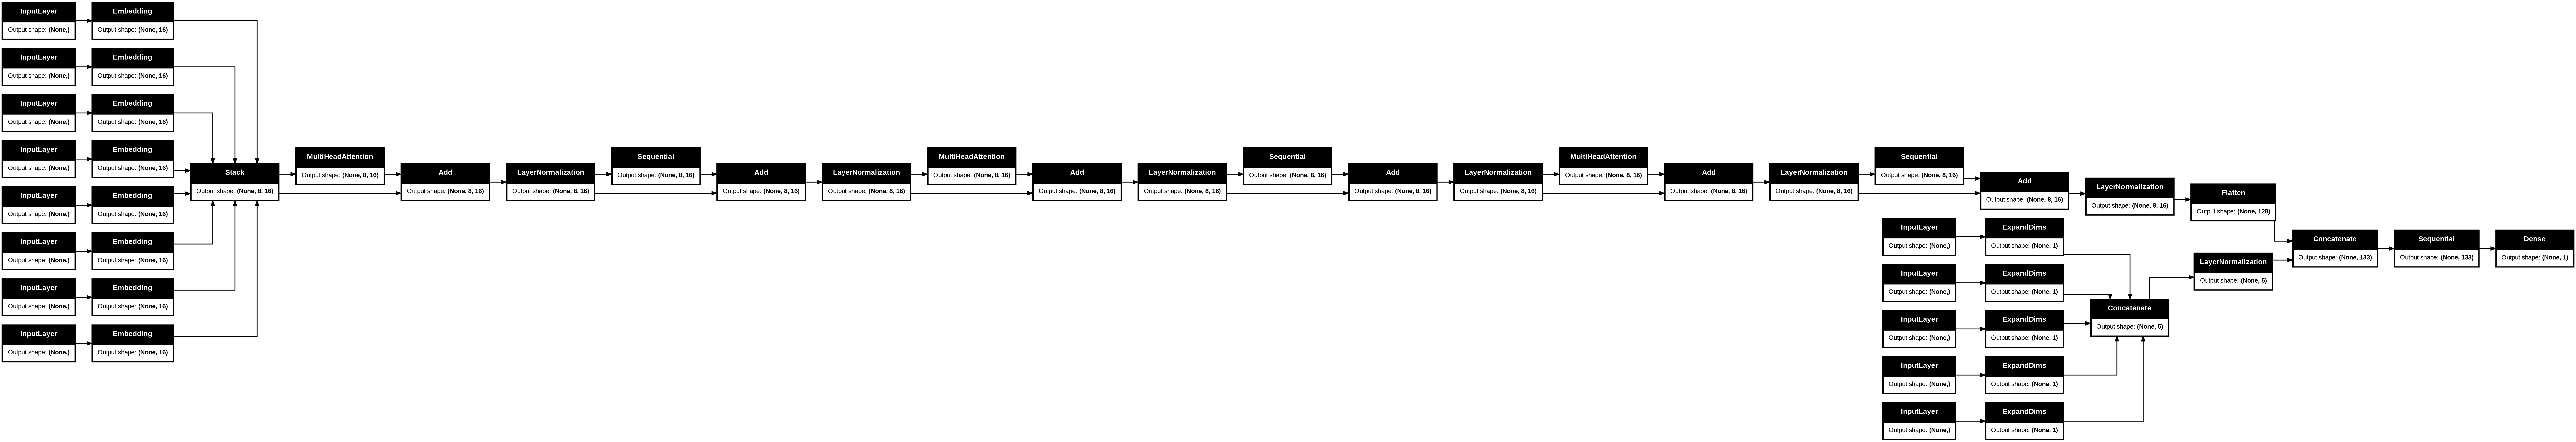

In [96]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = ops.stack(encoded_categorical_feature_list, axis=1)
    # <KerasTensor shape=(None, Num_categorical_features, embedding_dims), dtype=float32, sparse=False, name=keras_tensor_13>
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)
    # <KerasTensor shape=(None, Num_numerical_features), dtype=float32, sparse=False, name=keras_tensor_14>

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(
                layers.LayerNormalization, epsilon=1e-6
            ),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

# Model compile and Training

In [104]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
    class_weight,
):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy"),],
    )

    callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0
    )
    ]
    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    # using class_weight is not possible because we are using sample_weight
    history = model.fit(
        train_dataset, epochs=num_epochs,
        validation_data=validation_dataset,
        callbacks = callbacks,
        # class_weight = class_weight
    )
    print("Model training finished")

    # calculating metrics
    _, train_acc= model.evaluate(train_dataset, verbose=0)
    train_pred = model.predict(get_dataset_from_csv(train_data_file, batch_size))
    train_pred = [1 if p>0.5 else 0 for p in train_pred]
    train_actual = [0 if p== ' <=50K' else 1 for p in pd.read_csv(train_data_file, header=None).iloc[:, 14]]
    train_f1 = f1_score(train_actual, train_pred)
    train_cm = confusion_matrix(train_actual, train_pred)
    train_tn, train_fp, train_fn, train_tp = confusion_matrix(train_actual, train_pred).ravel()


    _, val_acc= model.evaluate(validation_dataset, verbose=0)
    val_pred = model.predict(validation_dataset)
    val_pred = [1 if p>0.5 else 0 for p in val_pred]
    val_actual = [0 if p== ' <=50K' else 1 for p in pd.read_csv(test_data_file, header=None).iloc[:, 14]]
    val_f1 = f1_score(val_actual, val_pred)
    val_cm = confusion_matrix(val_actual, val_pred)
    val_tn, val_fp, val_fn, val_tp = confusion_matrix(val_actual, val_pred).ravel()
    print(f"Train accuracy: {round(val_acc * 100, 2)}%")
    print(f"Train f1: {round(train_f1 * 100, 2)}%")
    print(f"Train tn, fp, fn, tp: {train_tn, train_fp, train_fn, train_tp}")

    print(f"Validation accuracy: {round(val_acc * 100, 2)}%")
    print(f"Val f1: {round(val_f1 * 100, 2)}%")
    print(f"Val tn, fp, fn, tp: {val_tn, val_fp, val_fn, val_tp}")

    return history, model

In [106]:
history, trained_model = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_path,
    test_data_file=test_data_path,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
    class_weight = class_weight
)

Start training the model...
Epoch 1/50
    123/Unknown 65s 212ms/step - accuracy: 0.8450 - loss: 59251.5000

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


123/123 ━━━━━━━━━━━━━━━━━━━━ 71s 263ms/step - accuracy: 0.8450 - loss: 59251.1367 - val_accuracy: 0.8433 - val_loss: 61585.9609
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8465 - loss: 59124.5547 - val_accuracy: 0.8447 - val_loss: 61510.2070
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8462 - loss: 58629.4688 - val_accuracy: 0.8422 - val_loss: 61352.9648
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8501 - loss: 58334.0156 - val_accuracy: 0.8429 - val_loss: 61447.4883
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8490 - loss: 58434.6680 - val_accuracy: 0.8434 - val_loss: 61419.8828
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8476 - loss: 58496.3828 - val_accuracy: 0.8443 - val_loss: 61280.6719
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8499 - loss: 58319.5117 - val_accuracy: 0.8447 - val_loss: 61670.8008
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/st

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Train accuracy: 84.45%
Train f1: 66.96%
Train tn, fp, fn, tp: (22989, 1731, 3023, 4818)
Validation accuracy: 84.45%
Val f1: 64.0%
Val tn, fp, fn, tp: (11500, 935, 1596, 2250)


# Plot the metrics

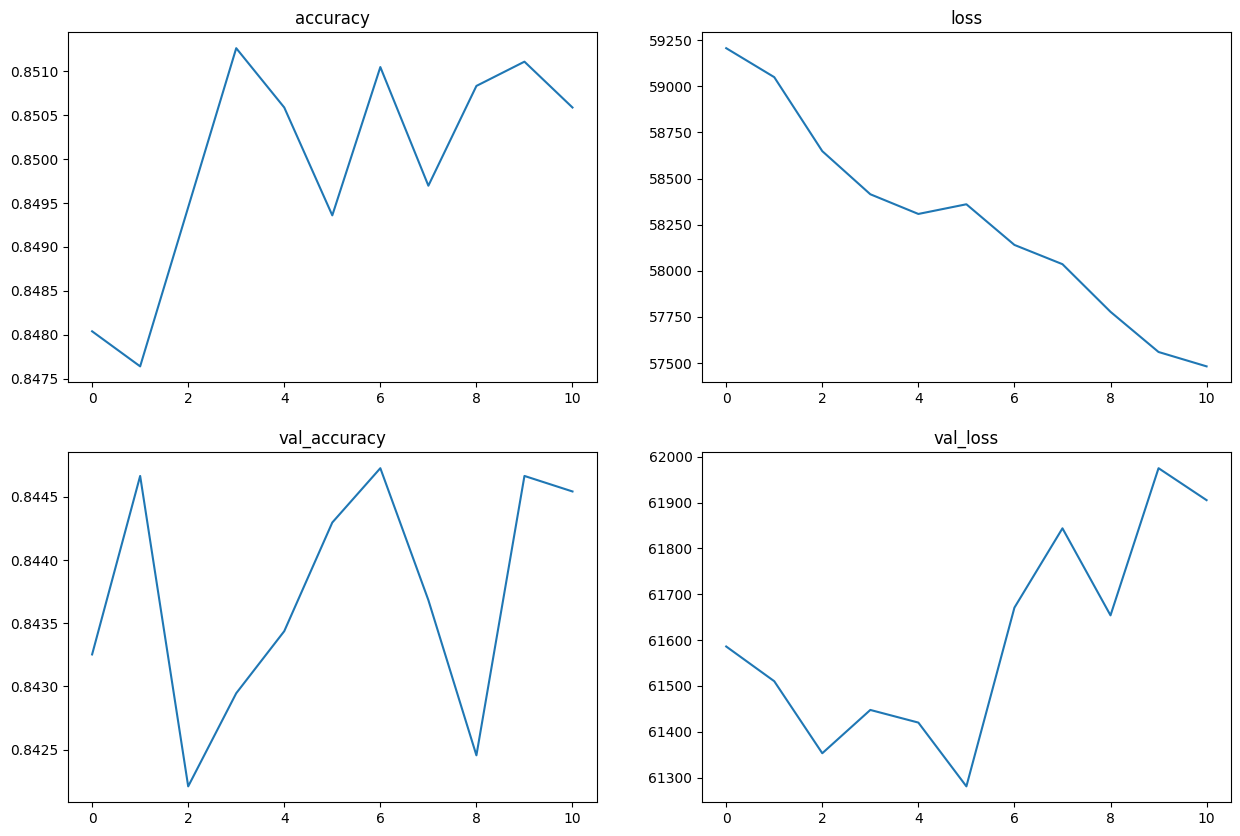

In [108]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = math.ceil(total_plots / cols)

    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, i+1)
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()
plot_history_metrics(history)